In [1]:
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from hydra import initialize, compose
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
import torch

from functools import partial
import sys

In [2]:
sys.path.append('../..')
device = 'cpu'

# Load the autoreload extension
%load_ext autoreload
# Set autoreload mode
%autoreload 2

from src.ScoreNetwork import ScoreNetwork
from src.DSBM_model_mod_v3 import DSBM
from src.test_fn import test_fn

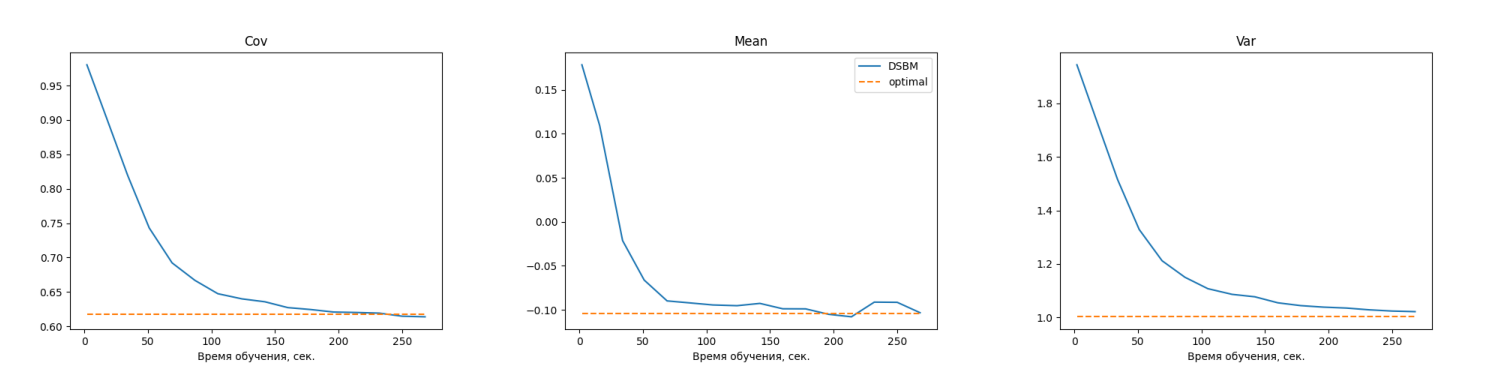

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
img1 = mpimg.imread('convergence_cov_inTime.png')
axes[0].imshow(img1)
axes[0].axis('off')

img2 = mpimg.imread('convergence_mean_inTime.png')
axes[1].imshow(img2)
axes[1].axis('off')

img3 = mpimg.imread('convergence_var_inTime.png')
axes[2].imshow(img3)
axes[2].axis('off')

plt.tight_layout()
plt.show()

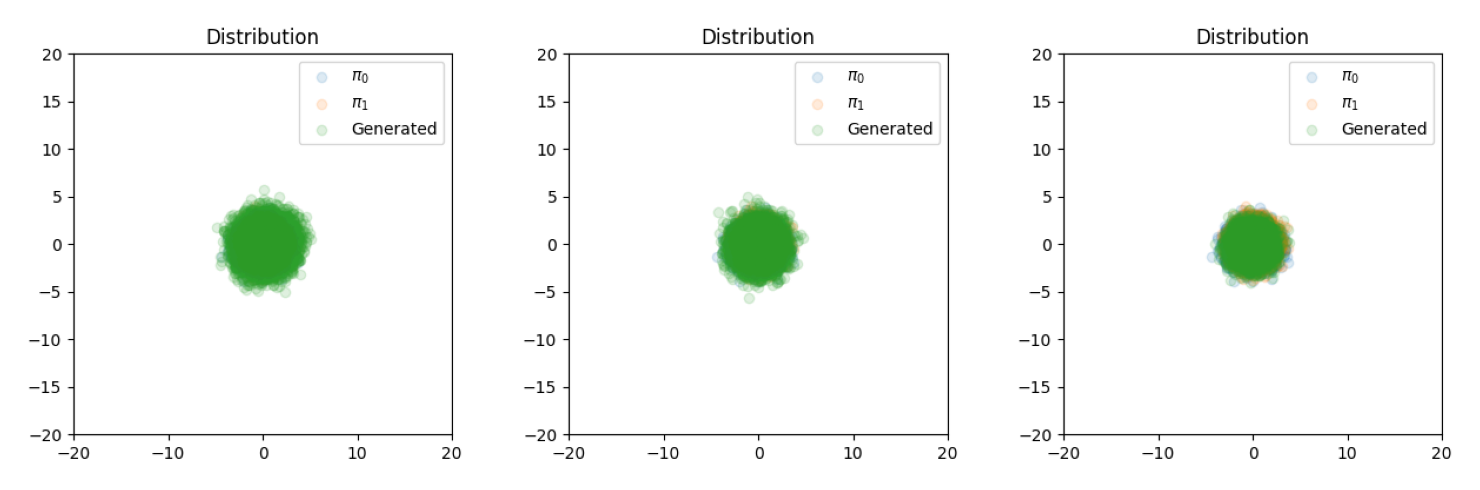

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
img1 = mpimg.imread('iter_2-b.png')
axes[0].imshow(img1)
axes[0].axis('off')

img2 = mpimg.imread('iter_20-b.png')
axes[1].imshow(img2)
axes[1].axis('off')

img3 = mpimg.imread('iter_100-b.png')
axes[2].imshow(img3)
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [5]:
with initialize(version_base=None, config_path="."):
    
    cfg: DictConfig = compose(config_name="config.yaml")

if cfg.get("seed"):
    pl.seed_everything(cfg.seed, workers=True)
print(cfg)

Seed set to 42


{'dataset_name': 'gaussian', 'model_name': 'DSBM', 'seed': 42, 'sigma': 1, 'num_steps': 200, 'net_hidden_layer_width': 64, 'activation_fn': 'torch.nn.SiLU', 'batch_size': 128, 'first_coupling': 'ref', 'inner_iters': 100, 'fb_sequence': ['b', 'f'], 'dataset_size': 10000, 'test_dataset_size': 10000, 'dim': 20, 'x0_mean': [-0.1], 'x0_vars_diag': [1], 'x0_cov_pairs': [], 'x1_mean': [0.1], 'x1_vars_diag': [1], 'x1_cov_pairs': [], 'paths': {'experiments_dir_name': 'gaussian_dim=20_а=0.1_var=1_hlw=64_EXP'}}


In [6]:
activation_fn = hydra.utils.get_class(cfg.activation_fn)()
hidden_size = cfg.net_hidden_layer_width
dim = cfg.dim
net_fn = partial(ScoreNetwork, input_dim=dim+1, layer_widths=[hidden_size, hidden_size, dim], activation_fn=activation_fn)  

num_steps = cfg.num_steps
sigma = cfg.sigma
inner_iters = cfg.inner_iters
batch_size = cfg.batch_size


model = DSBM(net_fwd=net_fn().to(device), 
             net_bwd=net_fn().to(device), 
             num_steps=num_steps, sig=sigma, first_coupling=cfg.first_coupling)

model_list = torch.load("model_list.pt")

model.load_state_dict(model_list[-1]['model'])

<All keys matched successfully>

In [7]:
df_SWD = test_fn(cfg, model, N_samples = 10)
df_SWD

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


,sample_№,"inference_time, сек.",2-WD_max,2-WD,"delta_W, %",mean_opt,mean,"delta_mean, %",var_opt,var,"delta_var, %",cov
0,0,0.821486,0.900512,0.718760,20.183154,-0.099026,0.030932,131.235870,0.999825,1.077442,7.763036,0.637988
1,1,0.845494,0.886595,0.695961,21.501855,-0.099026,0.026603,126.864256,0.999825,1.076511,7.669870,0.636567
2,2,0.825894,0.913773,0.725378,20.617242,-0.099026,0.029839,130.132266,0.999825,1.082107,8.229548,0.638672
3,3,0.773063,0.875408,0.704786,19.490491,-0.099026,0.025461,125.711306,0.999825,1.083838,8.402717,0.640481
4,4,0.796048,0.909215,0.722293,20.558603,-0.099026,0.030272,130.569779,0.999825,1.085353,8.554211,0.646793
5,5,0.829300,0.883945,0.696028,21.258896,-0.099026,0.024162,124.399152,0.999825,1.078941,7.912920,0.640239
6,6,0.780898,0.912700,0.709403,22.274201,-0.099026,0.030932,131.235845,0.999825,1.077676,7.786429,0.641734
7,7,0.782058,0.899650,0.708953,21.196758,-0.099026,0.031694,132.005534,0.999825,1.076325,7.651282,0.637164
8,8,0.810026,0.913209,0.711869,22.047515,-0.099026,0.032552,132.872049,0.999825,1.069328,6.951472,0.632655
9,9,0.794965,0.905083,0.707335,21.848652,-0.099026,0.028760,129.042925,0.999825,1.078477,7.866540,0.637116


In [4]:
pd.read_csv('df_wasserstein_distance.csv')

,Unnamed: 0,sample_№,"inference_time, сек.",2-WD_opt,2-WD,"delta_W, %",mean_opt,mean,"delta_mean, %",var_opt,var,"delta_var, %",cov
0,0,0,0.054015,0.869687,0.897832,3.236186,-0.095004,-0.098792,3.987749,0.999506,1.018194,1.869696,0.605006
1,1,1,0.049040,0.886718,0.939767,5.982655,-0.095004,-0.108227,13.918105,0.999506,1.030241,3.074973,0.619508
2,2,2,0.043893,0.919191,0.875432,4.760534,-0.095004,-0.097509,2.637163,0.999506,1.029455,2.996423,0.616588
3,3,3,0.056373,0.910292,0.916680,0.701794,-0.095004,-0.108262,13.955372,0.999506,1.024395,2.490141,0.605563
4,4,4,0.047819,0.857071,0.895295,4.459885,-0.095004,-0.103849,9.310297,0.999506,1.015503,1.600460,0.606000
5,5,5,0.046922,0.892021,0.884160,0.881325,-0.095004,-0.098715,3.906408,0.999506,1.027206,2.771340,0.616084
6,6,6,0.056545,0.871378,0.889758,2.109245,-0.095004,-0.103309,8.741465,0.999506,1.037762,3.827531,0.620021
7,7,7,0.039206,0.876459,0.894344,2.040626,-0.095004,-0.112815,18.747312,0.999506,1.027691,2.819894,0.606237
8,8,8,0.048154,0.881946,0.871189,1.219756,-0.095004,-0.097954,3.105166,0.999506,1.025639,2.614622,0.613252
9,9,9,0.038602,0.886829,0.903012,1.824818,-0.095004,-0.102680,8.079770,0.999506,1.035497,3.600874,0.618539
